# Modeling coronva virus in Germany

Fit a very simple infection model and compare it to the current numbers of Germany.

First run `git clone https://github.com/CSSEGISandData/COVID-19.git && cd COVID-19`

In [1]:
!date

So 8. Mär 23:44:22 CET 2020


<div class="alert alert-block alert-info"><b>Note:</b> This uses a very simple model (SIR model) and assumes that no further measures will be taken to curb spread of the virus. The model's recovery rate is set to 1/14 (2 weeks average).</div>

## imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%pylab inline

from itertools import chain

import numpy as np
from scipy.integrate import odeint
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## parameters

### plotting

In [3]:
plt.style.use('seaborn')
FS = 16  # font size

### modeling

According to this paper, R0, the basic reproduction number, is between 4.7 and 6.6: https://www.medrxiv.org/content/10.1101/2020.02.07.20021154v1.full.pdf

Assuming that 0.5% of infected people die

In [4]:
R0 = 6.6                  # use conservative estimate
R0 = 2.8
gamma = 1. / 14           # mean recovery rate
beta = R0 * gamma         # contact or infection rate
death = 0.005 * gamma     # mortality rate
N = 80000000              # total population

include_mortality = False # whether to include virus induced mortality to the model

## load current data

In [5]:
!ls csse_covid_19_data/csse_covid_19_time_series/

README.md			    time_series_19-covid-Deaths.csv
time_series_19-covid-Confirmed.csv  time_series_19-covid-Recovered.csv


In [6]:
def load_data(path, country='Germany'):
    df = pd.read_csv(path)
    df = df.rename(columns={'Country/Region': 'country'})
    df = df.query(f'country=={country!r}')
    df.index = ['cases']
    df = df.T.tail(-4).reset_index()  # drop non-case values like lat and long
    df = df.assign(date=pd.to_datetime(df['index']))
    return df

In [7]:
!git pull origin master

From https://github.com/CSSEGISandData/COVID-19
 * branch            master     -> FETCH_HEAD
Already up to date.


In [8]:
df = load_data('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [9]:
dfd = load_data('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

In [10]:
dfr = load_data('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

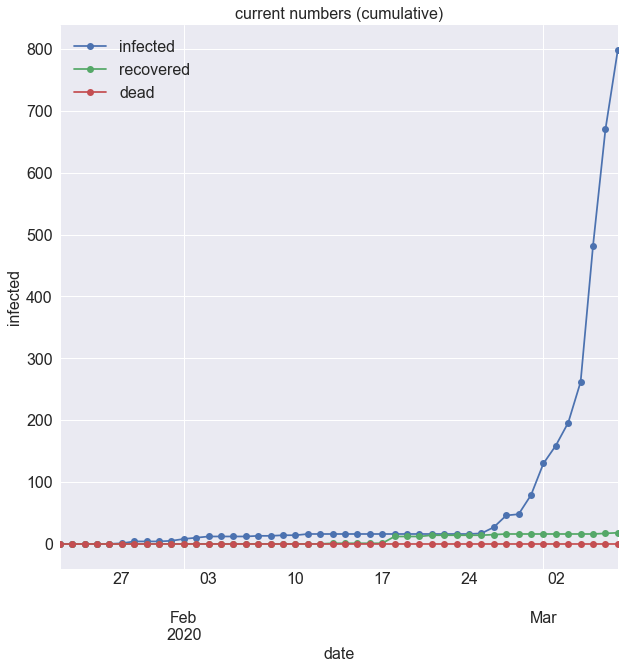

In [11]:
ax = df.plot(x='date', y='cases', figsize=(10, 10), fontsize=FS, marker='o', label='infected')
ax = dfr.plot(x='date', y='cases', figsize=(10, 10), fontsize=FS, marker='o', label='recovered', ax=ax)
ax = dfd.plot(x='date', y='cases', figsize=(10, 10), fontsize=FS, marker='o', label='dead', ax=ax)
ax.set_xlabel('date', fontsize=FS)
ax.set_ylabel('infected', fontsize=FS)
ax.legend(fontsize=FS)
ax.set_title('current numbers (cumulative)', fontsize=FS);

## model

Simple SIR model, see: https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease

Model code from here: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [12]:
# Initial number of infected and recovered individuals, inf0 and rec0.
inf0, rec0, dead0 = 1, 0, 0
# Everyone else, sus0, is susceptible to infection initially.
sus0 = N - inf0 - rec0 - dead0
# A grid of time points (in days)
t = np.arange(200)

In [13]:
# The SIR model differential equations.
def deriv_without_mortality(y, t, N, beta, gamma):
    """
    * S: susceptible
    * I: infected
    * R: recovered
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [14]:
# with mortality
def deriv_with_mortality(y, t, N, beta, gamma, death):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + death) * I
    dRdt = gamma * I
    dDdt = death * I
    return dSdt, dIdt, dRdt, dDdt

In [15]:
deriv = deriv_with_mortality if include_mortality else deriv_without_mortality

In [16]:
if include_mortality:
    y0 = sus0, inf0, rec0, dead0
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, death))
    S, I, R, D = ret.T
else:
    y0 = sus0, inf0, rec0
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

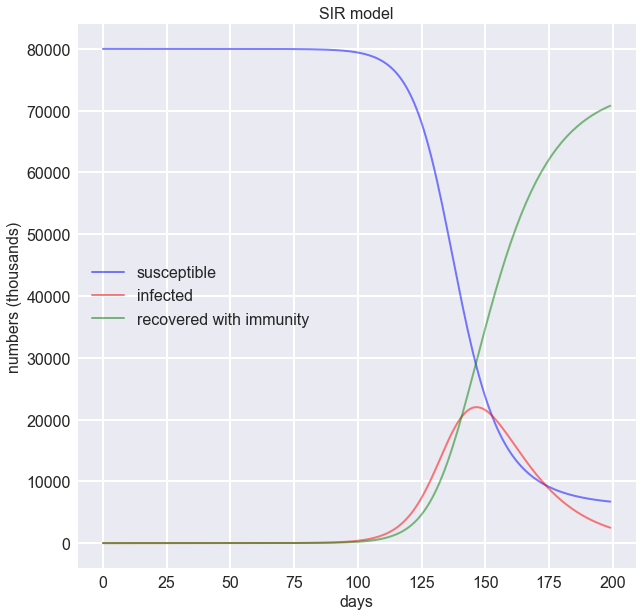

In [17]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='recovered with immunity')
if include_mortality:
    ax.plot(t, D/1000, 'k', alpha=0.5, lw=2, label='dead')

ax.set_xlabel('days', fontsize=FS)
ax.set_ylabel('numbers (thousands)', fontsize=FS)
ax.set_title('SIR model', fontsize=FS)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize=FS)
legend.get_frame().set_alpha(0.5)
for tick in chain(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
    tick.label.set_fontsize(FS)

## comparison

### "fit" real and model

In [18]:
def msle(x, y):
    xlog = np.log1p(x)
    ylog = np.log1p(y)
    return ((xlog - ylog) ** 2).mean()

In [19]:
def mse(x, y):
    return ((np.array(x) - np.array(y)) ** 2).mean()

In [20]:
def mae(x, y):
    return abs(np.array(x) - np.array(y)).mean()

In [21]:
def calculate_offset(real, model, metric=mse):
    """'Fit' the model to the data be calculating best offset

    Move data from left to right to find the point at which
    the MSLE is minimized. Effectively, it is assumed that
    the onset of the outbreak is a free variable.

    This could be considered "fitting" the model to the data.

    """
    m = len(real)
    n = len(model)
    assert n > 2 * m

    offsets = []
    for i in range(m):
        real_subset = real[i:]
        model_subset = model[:len(real_subset)]
        error = metric(real_subset, model_subset)
        offsets.append((i, error))

    return min(offsets, key=lambda tup: tup[1])[0]

In [29]:
offset = calculate_offset(df['cases'].astype(float), I)
print(f"calculated offset: {offset}")

calculated offset: 0


In [23]:
cases = df['cases'][offset:].values
infected = I[:len(cases) + 3]  # project +3d

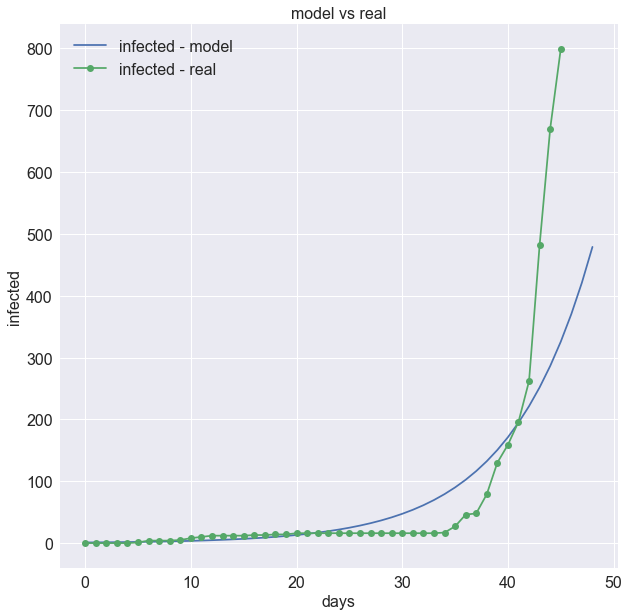

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(infected, label='infected - model')
ax.plot(cases, marker='o', label='infected - real')
if include_mortality:
    ax.plot(D[:len(cases) + 3], label='dead - model')

ax.legend(fontsize=FS)
ax.set_xlabel('days', fontsize=FS)
ax.set_ylabel('infected', fontsize=FS)
ax.set_title('model vs real', fontsize=FS)
for tick in chain(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
    tick.label.set_fontsize(FS)

### project numbers

In [25]:
current = df['cases'].values[-1]
print("current number of infected: {}".format(current))

current number of infected: 799


In [26]:
# where are we now in the model?
idx = np.argmin(abs(I - current))

In [27]:
print("maximum number of infected: {}, reached in {} days".format(int(max(I)), np.argmax(I) - idx))
if include_mortality:
    print("total deaths: {}".format(int(D[-1])))

maximum number of infected: 22000900, reached in 95 days


In [28]:
print("21 days projection", end="\n\n")
sl = slice(idx - 1, idx + 22)
if include_mortality:
    print("day   infected       dead")
    for i, (infected, dead) in enumerate(zip(I[sl], D[sl]), start=-1):
        print(f" {i:>2} {int(infected): >10} {int(dead): >10}")
else:
    print("day   infected")
    for i, infected in enumerate(I[sl], start=-1):
        print(f" {i:>2} {int(infected): >10}")

21 days projection

day   infected
 -1        704
  0        800
  1        910
  2       1035
  3       1177
  4       1339
  5       1523
  6       1732
  7       1969
  8       2239
  9       2547
 10       2896
 11       3294
 12       3746
 13       4259
 14       4844
 15       5508
 16       6264
 17       7123
 18       8101
 19       9212
 20      10475
 21      11912
